# Mappings between Disks and Polygons

Mappings between squares and disks have applications in computer graphics, and are interesting mathematically. Mappings between triangles and disks are less well-studied, but also interesting. Here, some mappings between triangles and disks are introduced. These mappings can be compared to mappings between squares and disks, and in many cases they suggest analogous mappings between higher polygons and disks.

The mapping from the polygon to the disk is the forward mapping: the inverse from the disk to the polygon is the inverse map. All the mappings in this workbook are [homeomorphisms](https://en.wikipedia.org/wiki/Homeomorphism): i.e. the forward map is continuous, and so is the inverse map. (Another term for this is "bicontinuous.") There are other desirable qualities a mapping may have:

* [Diffeomorphism](https://en.wikipedia.org/wiki/Diffeomorphism): The forward map and inverse map are both differentiable. In terms of appearance, smooth lines stay smooth.
* Radial: Points on lines through the origin remain on that line. If expressed in polar coordinates as $r, \theta$, the mapping preserves $\theta$.
* Equal-Area: Relative areas are preserved. Analytically, this means the [Jacobian determinant](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of the mapping is constant.
* [Conformal](https://en.wikipedia.org/wiki/Conformal_map): Local angles and orientation are preserved, except at the polygon vertices. All conformal mappings are diffeomorphisms.
* Mappings which preserve (proportional) distances. This isn't possible for the entire domain, but can be for certain cases, e.g. along the edges of the polygon/disk, or along lines between the vertices and the center.
* [Closed-form](https://en.wikipedia.org/wiki/Closed-form_expression): Can be expressed in terms of a finite number of defined functions and operations. This of course depends on what you accept as a defined function: here it means functions included in NumPy or SciPy.
* Simple: How simple or complicated is the formula? This is, of course, somewhat subjective.

This notebook only looks at mappings that preserve polygonal symmetry, because that allows one to draw analogies between the square and triangle case. So e.g. the approximate area preserving variant 2 in Reynolds 2017 isn't included, and neither are the vertical and horizontal stretches in Fong 2017. Also excluded are square mappings for which an analogous triangular mappings hasn't yet been derived, such as the elliptical mapping in Nowell 2005 and some mappings from Fong 2017. 

The code used for the mappings given may not be the most numerically efficient version; rather, a version that is easier to understand is presented. Closed-form inverses have not yet been derived for all mappings listed here. In the case where a closed-form inverse is not known, a numerical inverse is calculated. 

Citations (aside from the Wikipedia links sprinkled throughout):

1. [Peter Shirley, Kenneth Chiu. A Low Distortion Map Between Disk and Square. Journal of graphics tools, 2(3):45–52, 1997.](https://pdfs.semanticscholar.org/4322/6a3916a85025acbb3a58c17f6dc0756b35ac.pdf)
2. [John H. Mathews, Russell W. Howell. 11.9  The Schwarz-Christoffel Transformation, Extra Example 5. 2003.](http://mathfaculty.fullerton.edu/mathews/c2003/schwarzchristoffel/SchwarzChristoffelMod/Links/SchwarzChristoffelMod_lnk_10.html)
3. [Philip Nowell. Mapping a square to a circle. 2005.](http://mathproofs.blogspot.com/2005/07/mapping-square-to-circle.html)
4. [Chamberlain Fong. Analytical Methods for Squaring the Disc. arXiv:1509.06344, 2015.](https://arxiv.org/abs/1509.06344)
5. [Martin Lambers. Mappings between sphere, disc, and square. Journal of Computer Graphics Techniques Vol, 5(2), 2016.](http://jcgt.org/published/0005/02/01/)
6. [Marc B Reynolds. Square/Disc Mappings. 2017.](http://marc-b-reynolds.github.io/math/2017/01/08/SquareDisc.html)
7. [Chamberlain Fong. Elliptification of Rectangular Imagery. arXiv:1709.07875, 2017.](https://arxiv.org/abs/1709.07875)


In [1]:
#usual boilerplate
import numpy as np
from scipy.special import hyp2f1, gamma, ellipj, ellipk, ellipkinc
from scipy.optimize import minimize
import matplotlib.pyplot as plt
np.seterr(all='ignore')#silence div by 0 etc. warnings
eps = np.finfo(float).eps

def sqrt_safe(x):
    return np.sqrt(np.maximum(0, x))

# Standard polygons and disk

Points in the plane can be represented equivalently as complex numbers $z = x + i y$, or as a vector $z = \left<x,y\right>$. It's an abuse of notation, but I'll use the two notations interchangeably. Points on the disk will be denoted $z_{uv} = u + i v = \left<u,v\right>$, and points on the polygon will be denoted $z_{xy} = x + i y = \left<x,y\right>$. In the Python implementation here, the complex form is always used, mostly for the sake of taking advantage of the built-in data structure.

The standard disk is the unit disk $|z_{uv}| \le 1$. The standard square for graphics is $z_{xy}$ such that $x$ and $y$ are in $[-1, 1]$. There's no common definition of a standard triangle, but it is defined here using the third roots of unity: it is the triangle with vertices $z_0 = 1$, $z_1 = \exp(\frac{2i \pi}{3}) = -\frac{1}{2} + i\frac{\sqrt{3}}{2}$, and $z_2 = \exp(-\frac{2i \pi}{3}) = -\frac{1}{2} - i\frac{\sqrt{3}}{2}$. 

$x$ and $y$ cartesian coordinates reflect the symmetries of the square. Barycentric coordinates reflect the symmetries of the triangle, and their use can simplify triangle mappings (although that's not necessarily so). The barycentric coordinates of a point $z$ are $\beta_0, \beta_1, \beta_2$ such that $\beta_0 + \beta_1 + \beta_2 = 1$ and $z_{xy} = z_0 \beta_0 + z_1 \beta_1 + z_2 \beta_2$. In terms of matrices:

$$
\begin{bmatrix}1 & -\frac{1}{2} & -\frac{1}{2} \\
0 & \frac{\sqrt{3}}{2} & -\frac{\sqrt{3}}{2} \\
1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}\beta_0  \\
\beta_1  \\
\beta_2
\end{bmatrix}
=
\begin{bmatrix}x  \\
y  \\
1
\end{bmatrix},\quad
\frac{1}{3}
\begin{bmatrix}
2 & 0 & 1 \\
-1 & \sqrt{3} & 1 \\
-1 & -\sqrt{3} & 1
\end{bmatrix}
\begin{bmatrix}x  \\
y  \\
1
\end{bmatrix}
=
\begin{bmatrix}\beta_0  \\
\beta_1  \\
\beta_2
\end{bmatrix}
$$

[Polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system) will also come in useful:

$$
x = r \cos \theta,\, y = r \sin \theta
$$
$$
r = \sqrt{x^2 + y^2}, \theta = \arctan(y, x)
$$

where the 2-parameter form of arctan is used ([arctan2](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arctan2.html) in numpy).

Other standard $n$-sided polygons can be defined using the $n$th roots of unity. However, that definition with $n=4$ is not the same as the standard square defined earlier: it is a rotated and scaled version of it.

In [2]:
#disk
theta = np.arange(0,24) *np.pi/12
r = np.clip(np.linspace(0,1,num=5),0,1)
std_disk = (r[:,np.newaxis] * np.exp(1j*theta)).flatten()[23:]
del theta, r

#square
square = (np.mgrid[0:11,0:11] - 5)/5
std_square = square[0] + 1j*square[1]
sq_pts = np.array([1+1j, -1+1j, -1-1j, 1-1j])
del square

#triangle
b = (np.mgrid[0:13,0:13]/12).reshape([2,-1])
b3 = 1 - np.sum(b, axis=0)
index = b3 >= -0.01
bary = np.vstack([b[0][index],b[1][index],b3[index]]) #shape 3, ...
tri_pts = np.exp(2j*np.pi/3*np.arange(3))
def b2t(bary, triangle=tri_pts):
    return triangle @ bary
std_tri = b2t(bary)
del b, b3, index

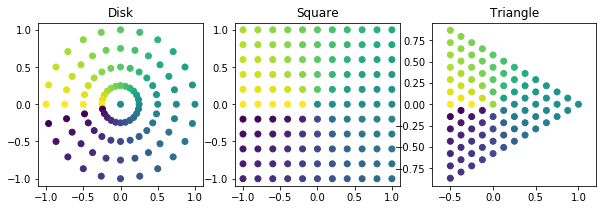

In [3]:
plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.title('Disk')
plt.axis('equal')
plt.scatter(std_disk.real, std_disk.imag, c=np.angle(std_disk))
plt.subplot(1, 3, 2)
plt.title('Square')
plt.axis('equal')
plt.scatter(std_square.real, std_square.imag, c=np.angle(std_square))
plt.subplot(1, 3, 3)
plt.title('Triangle')
plt.axis('equal')
plt.scatter(std_tri.real, std_tri.imag, c=np.angle(std_tri))
plt.show()

Since the mappings are all symmetric about the center, they can be thought of as performing the mapping in one triangular sector of the polygon and then rotating a copy into the other sectors. See the diagram below: the square's 90-degree sectors are labeled with compass directions, while the triangle's 120-degree sectors are labelled with opposing point's index. For the square, its sectors are defined as so: N: $y \ge 0, |x| \le |y|$, S: $y \le 0, |x| \le |y|$, W: $x \le 0, |x| \ge |y|$, E: $x \ge 0, |x| \ge |y|$. For the triangle, sector $i$ is such that $ \beta_i = \min_j \beta_j$, or in terms of $\theta$, sector 2 has $\theta \in [0,\frac{2\pi}{3}]$, sector 1 has $\theta \in [-\frac{2\pi}{3},0]$, and sector 0 is the remainder. Calculations can be simplified by calculating one sector and then rotating it into the other sectors. For squares, this rotation can easily be specified by permutation and/or negation of $x$ and $y$: for triangles, the rotation is a cyclic permutation of the $\beta_i$s. A particular mapping for a sector may, when used on points outside its sector, take the same values as the corresponding mappings on other sectors, which may allow for further optimization.

The radial stretch, equal-area, and approximate equal-area mappings explicitly use this construction. Mappings for other $n$-polygons can be derived from the mappings for the square (or triangle) by this series of composed mappings:

* A mapping from a x-degree sector of the $n$-polygon to a 90-degree sector of the square. This is a composition of rotations, scaling, and shearing, and can be expressed as a matrix. It preserves area but is not conformal.
* A mapping from the square to the disk.
* A mapping from a 90-degree sector of the disk to an x-degree sector of the disk. This can be performed by scaling $\theta$, or conformally by the function $f(z) = z^\frac{x}{90}$.

This derivation will not produce a conformal mapping or a diffeomorphism. The first and third mappings are easily invertible, so if the the mapping from the square to the disk has a closed-form inverse the inverse of the whole thing will also has a closed-form.

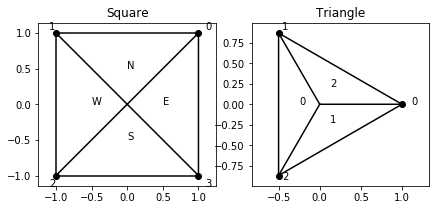

In [4]:
plt.figure(figsize=(7,3))
plt.subplot(1, 2, 1)
plt.title('Square')
plt.axis('equal')
plt.plot(sq_pts.real, sq_pts.imag, c='k')
sq_pts2 = sq_pts[[1,3,0,2]]
plt.plot(sq_pts2.real, sq_pts2.imag, c='k')
plt.scatter(sq_pts.real, sq_pts.imag, c='k')
for pt,name in zip(sq_pts*1.1-0.05j, range(4)):
    plt.annotate(name, (pt.real, pt.imag))    
for pt,name in zip(sq_pts*(1+1j)/4, ['N','W','S','E']):
    plt.annotate(name, (pt.real, pt.imag))

plt.subplot(1, 2, 2)
plt.title('Triangle')
plt.axis('equal')
plt.plot(tri_pts.real, tri_pts.imag, c='k')
tri_pts2 = np.array([tri_pts[1], 0, tri_pts[0], tri_pts[2], 0])
plt.plot(tri_pts2.real, tri_pts2.imag, c='k')
plt.scatter(tri_pts.real, tri_pts.imag, c='k')
for pt,name in zip(tri_pts*1.05+0.07, range(3)):
    plt.annotate(name, (pt.real, pt.imag))
for pt,name in zip(-tri_pts/4, range(3)):
    plt.annotate(name, (pt.real, pt.imag))

plt.show()

# Conformal

This is perhaps the mapping with the longest history. Due to the theory of complex analysis, conformal maps are best expressed in terms of complex functions. The [Schwarz-Christoffel mapping](https://en.wikipedia.org/wiki/Schwarz%E2%80%93Christoffel_mapping) gives a mapping from the upper half-plane to a simple polygon. A map from the unit disk to the upper half-plane is just a [
Möbius transformation](https://en.wikipedia.org/wiki/M%C3%B6bius_transformation). The hard part is solving the integral in the Schwarz-Christoffel mapping, which usually results in formula involving special functions.

The formulas for the conformal map from the square to the disk and its inverse are lengthy: see Lambers 2016 (or the code below). It involves the [Jacobi elliptic functions](https://en.wikipedia.org/wiki/Jacobi_elliptic_functions) for the forward mapping and the [elliptic integral](https://en.wikipedia.org/wiki/Elliptic_integral) for the inverse mapping. Most numerical software packages (including SciPy) only implement these functions for real numbers, so a work-around has to be used to apply these mappings to complex numbers.

The formula for the conformal map from the disk to the triangle is shorter to write but not simpler to calculate. 

$$ 
  z_h = \frac{z_{uv}+1}{z_{uv}-1}, \,
  z_{xy} = -
  \frac{3}{\sqrt{\pi}}
  \frac{ \Gamma\left({5/6}\right) }
  { \Gamma\left({1/3}\right) }
  z_h\, {}_2 F_1 \left(\frac{1}{2},\frac{2}{3};\frac{3}{2}; -3 z_h^2\right)
  -\frac{1}{2}
$$

$z_{uv}$ is a point on the disk, $z_h$ is a point on the (right) half-plane, and $z_{xy}$ is a point on the triangle. $\Gamma(x)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function), and ${}_2 F_1 \left(a,b;c; z\right)$ is the [hypergeometric function](https://en.wikipedia.org/wiki/Hypergeometric_function). This is rotated, translated, scaled, and simplified from the formula in Mathews et al. 2003. Fortunately, SciPy does implement the hypergeometric function for complex values. Unfortunately, a closed-form inverse of the hypergeometric function (in general, and for these specific arguments) is not known, so a numerical inversion is used here.

In [5]:
k = ellipk(1/2)

def d2s_conf(z):
    """Conformal map, disk to square"""
    diskp = z*(1+1j)/np.sqrt(2)
    up = diskp.real
    vp = diskp.imag
    A = up**2 + vp**2
    B = up**2 - vp**2
    T = np.sqrt((1+A**2)**2 - 4*B**2)
    U = 1 + 2*B - A**2
    alpha = np.arccos(np.clip((2*A-T)/U, -1, 1))
    beta = np.arccos(np.clip(U/(2*A+T), -1, 1))
    xp = np.sign(up)*(2*k - ellipkinc(alpha, 1/2))
    yp = np.sign(vp)*ellipkinc(beta, 1/2)
    return (xp + 1j*yp)*(1-1j)/2/k

conf_sq = d2s_conf(std_disk)

def complexcn(z):
    """Jacobi elliptical function cn with parameter 1/2, valid for complex numbers."""
    x = z.real
    y = z.imag
    snx, cnx, dnx, phx = ellipj(x, 1/2) 
    sny, cny, dny, phy = ellipj(y, 1/2) 
    numer = cnx * cny - 1j * snx * dnx * sny * dny
    denom = (1 - dnx**2 * sny**2)
    return numer / denom
    
def s2d_conf(z):
    """Conformal map, square to disk"""
    csp = z * (1+1j)/2
    w = complexcn(k*(1-csp))    
    return w * (1 - 1j)/np.sqrt(2)
conf_sqdisk = s2d_conf(std_square)

In [6]:
def d2t_conf(z, scale=1-eps):
    """Conformal map, disk to triangle"""
    #shrink disk by (1-eps) to avoid numerical instability along branch cuts of hyp2f1
    std_disk = scale*z
    hp1 = (std_disk+1)/(std_disk-1)
    return -3*gamma(5/6)/gamma(1/3)/np.sqrt(np.pi)*hp1*hyp2f1(1/2, 2/3, 3/2, -3*hp1**2)  -1/2
conf_tri = d2t_conf(std_disk)

In [7]:
#numerically invert
conf_tridisk = std_tri.copy()
for i in range(len(std_tri)):
    z = std_tri[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        return abs(d2t_conf(t.view(dtype=np.complex128)) - z)*1000 
    res = minimize(objective, x0=xy, method='Nelder-Mead')
    conf_tridisk[i] = res.x.view(dtype=np.complex128)

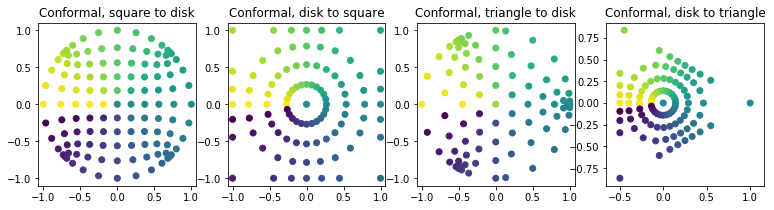

In [8]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Conformal, square to disk')
plt.axis('equal')
plt.scatter(conf_sqdisk.real, conf_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Conformal, disk to square')
plt.axis('equal')
plt.scatter(conf_sq.real, conf_sq.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Conformal, triangle to disk')
plt.axis('equal')
plt.scatter(conf_tridisk.real, conf_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Conformal, disk to triangle')
plt.axis('equal')
plt.scatter(conf_tri.real, conf_tri.imag, c=np.angle(std_disk))

plt.show()

# Radial Stretch

These are perhaps the simplest mappings. In polar form, $r$ is simply multiplied by a value depending on $\theta$. These mappings are not diffeomorphisms.

**Square to disk:**

$$
  z_{uv} = \frac{\max(|x|,|y|)}{|z_{xy}|}z_{xy}
$$
**Disk to square:**
$$
  z_{xy} = \frac{|z_{uv}|}{\max(|u|,|v|)}z_{uv} 
$$

The triangle mapping is more easily expressed in polar form.

**Triangle to disk:**
$$
r_{uv} = 1 - 3 \min {\beta_i}
$$
**Disk to triangle:**
$$
r_{xy} = \frac{r_{uv}}{2\cos\left(\mathrm{mod}\left(\theta_{uv},\frac{2\pi}{3}\right) - \frac{\pi}{3}\right)}
$$

In [9]:
def s2d_radial(z):
    """Radial stretch, square to disk"""
    sfactor = np.maximum(abs(z.real),abs(z.imag))/abs(z)
    sfactor[np.isnan(sfactor)] = 1 
    return sfactor*z

rs_sqdisk = s2d_radial(std_square)

def d2s_radial(z):    
    """Radial stretch, disk to square"""    
    dfactor = abs(z)/np.maximum(abs(z.real),abs(z.imag))
    dfactor[np.isnan(dfactor)] = 1 
    return dfactor*z

rs_square = d2s_radial(std_disk)

In [10]:
def b2d_radial(bary):
    """Radial stretch, triangle (barycentric) to disk"""
    tri = b2t(bary)
    c = np.angle(tri)
    r = 1 - 3*np.min(bary, axis=0)
    return r * np.exp(1j*c)

rs_tridisk = b2d_radial(bary)

def d2t_radial(z):    
    """Radial stretch, disk to triangle"""
    c = np.angle(z)
    r = abs(z)/(2*np.cos(c % (np.pi*2/3) - np.pi/3))
    return r * np.exp(1j*c)

rs_tri = d2t_radial(std_disk)

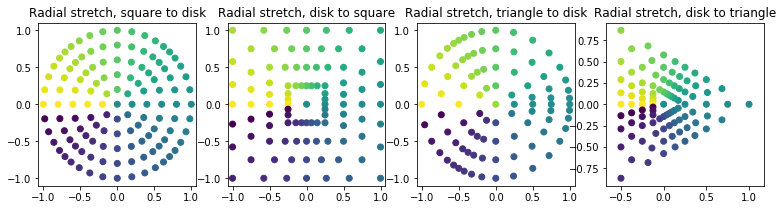

In [11]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Radial stretch, square to disk')
plt.axis('equal')
plt.scatter(rs_sqdisk.real, rs_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Radial stretch, disk to square')
plt.axis('equal')
plt.scatter(rs_square.real, rs_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Radial stretch, triangle to disk')
plt.axis('equal')
plt.scatter(rs_tridisk.real, rs_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Radial stretch, disk to triangle')
plt.axis('equal')
plt.scatter(rs_tri.real, rs_tri.imag, c=np.angle(std_disk))

plt.show()

# Concentric Equal-Area

The square mapping comes from Shirley et al. 1997, although the formula from Reynolds 2017 is used here. These mappings are best expressed as different cases for different segments of the polygon. They are not diffeomorphisms, but do preserve relative distances along the edges.

**Square to disk:**
$$
u = x \cos\left(\frac{\pi}{4} \frac{y}{x}\right),\,
v = x \sin\left(\frac{\pi}{4} \frac{y}{x}\right) \quad \textrm{where } x^2 \ge y^2
$$
$$
u = y \sin\left(\frac{\pi}{4} \frac{x}{y}\right),\,
v = y \cos\left(\frac{\pi}{4} \frac{x}{y}\right) \quad \textrm{where } x^2 \le y^2
$$
**Disk to square:**
$$
x = \mathrm{sign} (u) |z_{uv}|,\,
y = \frac{4}{\pi} |z_{uv}| \arctan\left(\frac{v}{|u|}\right) \quad \textrm{where } u^2 \ge v^2
$$
$$
x = \frac{4}{\pi} |z_{uv}| \arctan\left(\frac{u}{|v|}\right),\,
y = \mathrm{sign} (v) |z_{uv}| \quad \textrm{where } u^2 \le v^2
$$
**Triangle to disk:**
$$
u = (3 \beta_i-1) \cos \left(\frac{\pi}{3} \frac{\beta_{i+1} - \beta_{i-1}}{3\beta_i-1} + k_i\right), \,
v = (3 \beta_i-1) \sin \left(\frac{\pi}{3} \frac{\beta_{i+1} - \beta_{i-1}}{3\beta_i-1} + k_i\right)\quad \textrm{where } \beta_i = \min_j \beta_j
$$
where $k_0 = 0$, $k_1= \frac{2\pi}{3}$, and $k_2= -\frac{2\pi}{3}$.

**Disk to triangle:**

This uses the trick mentioned earlier: specify the inverse mapping for only the 0 sector, and use rotations to calculate the other two sectors.
$$
\beta_0 = \frac{1 - |z_{uv}|}{3},\,
\beta_1 = \frac{b - \beta_0 + 1}{2},\,
\beta_2 = \frac{-b - \beta_0 + 1}{2},\,
b = \frac{6}{\pi}|z_{uv}| \arctan \left(\frac{v}{|z_{uv}|-u}\right)
\quad \textrm{where } \theta_{uv} \in \left[\frac{2\pi}{3}, \frac{4\pi}{3}\right]
$$

In [12]:
def s2d_ea(z):
    """Equal-area, square to disk"""
    x = z.real
    y = z.imag
    ea_sqdisk = np.where(abs(x) >= abs(y),
                     x*np.exp(1j*np.pi/4*y/x),
                     1j*y*np.exp(-1j*np.pi/4*x/y))
    ea_sqdisk[np.isnan(ea_sqdisk)] = 0 
    return ea_sqdisk
ea_sqdisk = s2d_ea(std_square)

def d2s_ea(z):
    """Equal-area, disk to square"""
    u = z.real
    v = z.imag
    ea_square = np.where(abs(u) >= abs(v),
                np.sign(u)*abs(z)*(1 + 4j/np.pi*np.arctan(v/u)),
                np.sign(v)*abs(z)*(4/np.pi*np.arctan(u/v) + 1j))                
    ea_square[np.isnan(ea_square)] = 0 
    return ea_square
ea_square = d2s_ea(std_disk)

In [13]:
def b2d_ea(bary):
    """Equal area, triangle (barycentric) to disk"""
    eatri0 = (3*bary[0]-1)*np.exp(1j*np.pi/3 * (bary[1] - bary[2])/(3*bary[0]-1)) 
    eatri1 = (3*bary[1]-1)*np.exp(1j*np.pi/3 * ((bary[2] - bary[0])/(3*bary[1]-1) + 2) )
    eatri2 = (3*bary[2]-1)*np.exp(1j*np.pi/3 * ((bary[0] - bary[1])/(3*bary[2]-1) - 2) )

    mb = np.min(bary, axis=0)

    ea_tridisk = eatri0.copy()
    ea_tridisk[bary[1] == mb] = eatri1[bary[1] == mb]
    ea_tridisk[bary[2] == mb] = eatri2[bary[2] == mb]
    ea_tridisk[np.isnan(ea_tridisk)] = 0 
    return ea_tridisk
ea_tridisk = b2d_ea(bary)

def d2b_ea(z):
    """Equal area, disk to triangle (barycentric)"""
    ea_beta = np.zeros((3,len(z)))
    for i in range(3):
        this_disk = z * np.exp(i*np.pi*2j/3)
        mask = abs(np.angle(this_disk)) >= 2/3*np.pi
        uz = this_disk.real
        vz = this_disk.imag
        absz = abs(this_disk)
        beta0 = (1 - absz)/3
        b = 6/np.pi*absz*np.arctan(vz/(absz-uz))
        beta1 = b/2 - beta0/2 + 1/2
        beta2 = -b/2 - beta0/2 + 1/2
        ea_b = np.roll(np.vstack([beta0, beta1, beta2]),-i,axis=0)
        ea_beta[:,mask] = ea_b[:,mask]
    ea_beta[:,abs(z) < eps] = 1/3
    return ea_beta

beta_ea = d2b_ea(std_disk)
ea_tri = b2t(beta_ea)

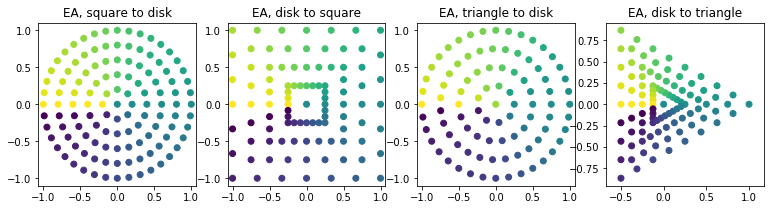

In [14]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('EA, square to disk')
plt.axis('equal')
plt.scatter(ea_sqdisk.real, ea_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('EA, disk to square')
plt.axis('equal')
plt.scatter(ea_square.real, ea_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('EA, triangle to disk')
plt.axis('equal')
plt.scatter(ea_tridisk.real, ea_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('EA, disk to triangle')
plt.axis('equal')
plt.scatter(ea_tri.real, ea_tri.imag, c=np.angle(std_disk))
plt.show()

# Approx Equal-Area

From Reynolds 2017, an approximation of the concentric equal-area mappings.

**Square to disk:**
$$
u = \mathrm{sign} (x) \sqrt{x^2-\frac{y^2}{2}},\,
v = \frac{y}{\sqrt{2}}\quad \textrm{where } x^2 \ge y^2
$$
$$
u = \frac{x}{\sqrt{2}},\,
v = \mathrm{sign} (y) \sqrt{y^2-\frac{x^2}{2}}\quad \textrm{where } x^2 \le y^2
$$
**Disk to square:**
$$
x = \mathrm{sign} (u) \sqrt{u^2+v^2},\,
y = \sqrt{2} v \quad \textrm{where } u^2 \ge v^2
$$
$$
x = \sqrt{2} u ,\,
y = \mathrm{sign} (v) \sqrt{u^2+v^2} \quad \textrm{where } u^2 \le v^2
$$
For triangles, again only the 0 sector has been specified, and rotations may be used to get the others.

**Triangle to disk:**
$$
u = (3 \beta_0-1) \sqrt{1- \frac{3}{4} \left(\frac{\beta_{1} - \beta_{2}}{3\beta_1-1}\right)^2 }, \,
v = \frac{\sqrt{3}}{2}\left(\beta_{1} - \beta_{2} \right)\quad \textrm{where } \beta_0 = \min_j \beta_j 
$$
**Disk to triangle:**
$$
\beta_0 = \frac{1 - |z_{uv}|}{3},\,
\beta_1 = \frac{2 + 2\sqrt{3} v + |z_{uv}|}{6},\,
\beta_2 = \frac{2 - 2\sqrt{3} v + |z_{uv}|}{6} \quad \textrm{where } \theta_{uv} \in \left[\frac{2\pi}{3}, \frac{4\pi}{3}\right]
$$

In [15]:
def s2d_aea(z):
    """Approximate equal-area, square to disk"""
    x = z.real
    y = z.imag
    aea_sqdisk = np.where(abs(x) >= abs(y),
                  x*np.sqrt(1-y**2/2/x**2) + 1j*y/np.sqrt(2),
                  x/np.sqrt(2) + 1j*y*np.sqrt(1-x**2/2/y**2) )
    aea_sqdisk[np.isnan(aea_sqdisk)] = 0 
    return aea_sqdisk
aea_sqdisk = s2d_aea(std_square)

def d2s_aea(z):
    """Approximate equal-area, disk to square"""    
    u = z.real
    v = z.imag    
    aea_square = np.where(abs(u) >= abs(v),
                np.sign(u)*abs(std_disk) + 1j*np.sqrt(2)*v,
                np.sqrt(2)*u + 1j*np.sign(v)*abs(std_disk))                
    aea_square[np.isnan(aea_square)] = 0 
    return aea_square
aea_square = d2s_aea(std_disk)

In [16]:
def b2d_aea(bary):
    """Approximate equal-area, triangle (barycentric) to disk"""
    aeatri0 = (3*bary[0]-1)*sqrt_safe(1- ((bary[1] - bary[2])/(3*bary[0]-1))**2*3/4) + 1j*np.sqrt(3)/2*(bary[1] - bary[2])
    aeatri1 = (3*bary[1]-1)*sqrt_safe(1- ((bary[2] - bary[0])/(3*bary[1]-1))**2*3/4) + 1j*np.sqrt(3)/2*(bary[2] - bary[0])
    aeatri2 = (3*bary[2]-1)*sqrt_safe(1- ((bary[0] - bary[1])/(3*bary[2]-1))**2*3/4) + 1j*np.sqrt(3)/2*(bary[0] - bary[1])

    mb = np.min(bary, axis=0)

    aea_tridisk = aeatri0.copy()
    aea_tridisk[bary[1] == mb] = aeatri1[bary[1] == mb]*np.exp(2j*np.pi/3)
    aea_tridisk[bary[2] == mb] = aeatri2[bary[2] == mb]*np.exp(-2j*np.pi/3)
    aea_tridisk[np.isnan(aea_tridisk)] = 0 
    return aea_tridisk
aea_tridisk = b2d_aea(bary)

def d2b_aea(z):
    """Approximate equal-area, disk to triangle (barycentric)"""    
    aea_beta = np.zeros((3,len(z)))
    for i in range(3):
        this_disk = z * np.exp(i*np.pi*2j/3)
        mask = abs(np.angle(this_disk)) >= 2/3*np.pi
        #uz = this_disk.real
        vz = this_disk.imag
        absz = abs(this_disk)
        beta0 = (1 - absz)/3
        beta1 = (2 + 2*np.sqrt(3)*vz + absz)/6
        beta2 = (2 - 2*np.sqrt(3)*vz + absz)/6        
        aea_b = np.roll(np.vstack([beta0, beta1, beta2]),-i,axis=0)
        aea_beta[:,mask] = aea_b[:,mask]
    #aea_beta[:,abs(z) < eps] = 1/3
    return aea_beta
    
beta_aea = d2b_aea(std_disk)
aea_tri = b2t(beta_aea)

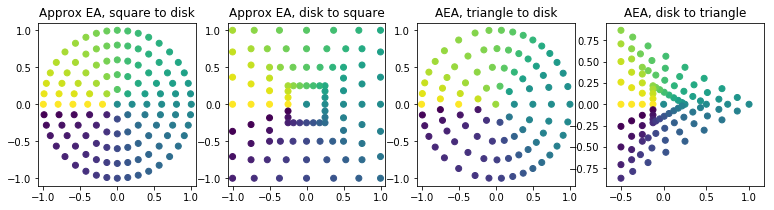

In [17]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Approx EA, square to disk')
plt.axis('equal')
plt.scatter(aea_sqdisk.real, aea_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Approx EA, disk to square')
plt.axis('equal')
plt.scatter(aea_square.real, aea_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('AEA, triangle to disk')
plt.axis('equal')
plt.scatter(aea_tridisk.real, aea_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('AEA, disk to triangle')
plt.axis('equal')
plt.scatter(aea_tri.real, aea_tri.imag, c=np.angle(std_disk))
plt.show()

# Squircle

Originating with Fong 2015. These are radial, and are also diffeomorphisms.

**Square to disk:**

$$
 z_{uv} = \frac{\sqrt{x^2+y^2-x^2 y^2}}{|z_{xy}|} z_{xy}
$$
**Disk to square:**

$$
 z_{xy} = s \left< \frac{1}{v}, \frac{1}{u} \right>,\,
 s = \frac{\mathrm{sign}(uv)}{\sqrt{2}} \sqrt{n - \sqrt{n (n-4 u^2 v^2)}}
$$
with $n = u^2 + v^2$.

**Triangle to disk:**

$$
 z_{uv} = \sqrt{\frac{1-27\beta_0\beta_1\beta_2}{\beta_0^2 + \beta_1^2 + \beta_2^2 - \beta_0\beta_1 - \beta_1\beta_2 - \beta_2\beta_0}} z_{xy} = \sqrt{\frac{3 y^2 + 6 x y^2 + 3 x^2 - 2 x^3}{x^2+y^2}} z_{xy}
$$

**Disk to triangle:** The $\sin$ and $\arcsin$ terms in this formula come about as [the solution of a cubic equation with three real roots](https://en.wikipedia.org/wiki/Cubic_function#Trigonometric_solution_for_three_real_roots). 

$$
z_{xy} = x \left(1 + i\frac{v}{u}\right)
$$
$$
x = \frac{1}{k} \sin \left(\frac{1}{3} \arcsin \left(2 u^2 k^2 - 1 \right) - q\right)
$$
$$
k= \frac{u^2 - 3v^2}{u^2+v^2}
$$

where $q = \frac{2\pi}{3}$ if $uk$ is negative and $0$ if $uk$ is positive. If $q=0$, then 
$z_{xy} = \frac{z_{uv}}{\sqrt{3}}$.

In [18]:
def s2d_sq(z):
    """Squircle, square to disk"""
    x = z.real
    y = z.imag
    sfactor = np.sqrt(x**2+y**2-x**2*y**2)/abs(z)
    sfactor[np.isnan(sfactor)] = 1 
    return sfactor*z
sr_sqdisk = s2d_sq(std_square)

def d2s_sq(z):
    """Squircle, disk to square"""
    u = z.real
    v = z.imag    
    n = u**2 + v**2
    s = np.sign(u*v)/np.sqrt(2) * sqrt_safe(n - sqrt_safe(n*(n-4*u**2*v**2)))
    sr_square = s * (1/v + 1j/u)
    index = (abs(z.real) < eps) | (abs(z.imag) < eps)
    sr_square[index] = z[index]
    return sr_square
sr_square = d2s_sq(std_disk)

In [19]:
#triangle
def b2d_sq(bary):
    """Squircle (trircle?), triangle (barycentric) to disk"""
    std_tri = b2t(bary)
    sfactor = (1 - 27 * np.product(bary, axis=0))/(np.sum(bary**2, axis=0) - np.sum(bary*np.roll(bary,1,axis=0), axis=0))
    #or sfactor = (6*x*y**2 -2*x**3 + 3*y**2 + 3*x**2) / (x**2 + y**2)
    
    sr_tridisk = sqrt_safe(sfactor)*std_tri
    return sr_tridisk
sr_tridisk = b2d_sq(bary)

def d2t_sq(z, eps=1E-6):
    """Squircle (trircle?), disk to triangle"""
    u = z.real
    v = z.imag
    us = u**2
    vs = v**2
    k = (us - 3*vs)/(us + vs)
    rots = np.where(u*k < 0, np.pi*2/3, 0)
    x = 1/k*(np.sin(1/3*np.arcsin(np.clip(2*us*k**2 - 1, -1, 1)) - rots) + 1/2)
    sr_tri = x *(1 + 1j*v/u)
    index = (abs(u) < eps) | (abs(k) < eps)
    sr_tri[index] = z[index]/np.sqrt(3)
    return sr_tri
sr_tri = d2t_sq(std_disk)

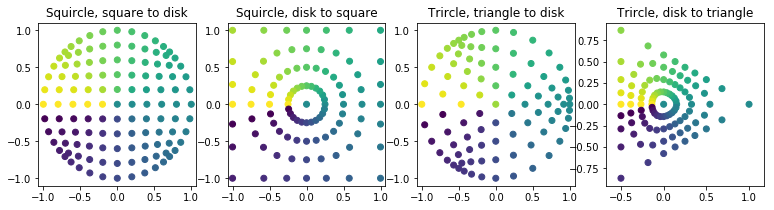

In [20]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Squircle, square to disk')
plt.axis('equal')
plt.scatter(sr_sqdisk.real, sr_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Squircle, disk to square')
plt.axis('equal')
plt.scatter(sr_square.real, sr_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Trircle, triangle to disk')
plt.axis('equal')
plt.scatter(sr_tridisk.real, sr_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Trircle, disk to triangle')
plt.axis('equal')
plt.scatter(sr_tri.real, sr_tri.imag, c=np.angle(std_disk))
plt.show()

# Naive Slerp

An original set of mappings, based on the naive slerp methods developed for the [the gco program in antitile](https://antitile.readthedocs.io/en/latest/gco-spherical.html#naive-slerp). These are diffeomorphisms and preserve distances along edges. The square naive slerp mappings also preserve diagonal lines ($y = x + k$ or $y = -x + k$ for some $k$).

The square elliptic mapping can be derived as an approximation of the square naive slerp mapping, in much the same way as the approximate equal-area mapping from the equal-area mapping.

**Square to disk:**
$$
u = \sqrt{2} \sin\left(\frac{\pi}{4}x\right) \cos\left(\frac{\pi}{4}y\right),\,
v = \sqrt{2} \cos\left(\frac{\pi}{4}x\right) \sin\left(\frac{\pi}{4}y\right)
$$
**Disk to square:**
$$
x = \frac{4}{\pi} \mathrm{sign}(u) \arccos\left( \frac{\sqrt{2+m+k}}{2} \right),\,
y = \frac{4}{\pi} \mathrm{sign}(v) \arccos\left( \frac{\sqrt{2-m+k}}{2} \right) 
$$
where $m = v^2 - u^2$ and $k = \sqrt{(m+2)^2 - 8 v^2}$.

**Triangle to disk:**
$$
u = \frac{1}{\sqrt{3}} \left(2 \sin \left(\frac{2\pi}{3} \beta_0\right)-\sin \left(\frac{2\pi}{3} \beta_1\right)-\sin \left(\frac{2\pi}{3} \beta_2\right)\right),\,
v = \sin\left(\frac{2\pi}{3} \beta_1\right)-\sin\left(\frac{2\pi}{3} \beta_2\right)
$$
or 
$$
z_{uv} = \frac{2}{\sqrt{3}}\sum^2_{i=0} \sin\left(\frac{2\pi}{3} \beta_i \right) z_i
$$
**Disk to triangle:** No closed form.

In [21]:
def s2d_ns(z):
    """Naive Slerp, Square to disk"""
    x = z.real
    y = z.imag    
    return np.sqrt(2)*(np.sin(np.pi/4*x)*np.cos(np.pi/4*y) + 1j*np.cos(np.pi/4*x)*np.sin(np.pi/4*y))
ns_sqdisk = s2d_ns(std_square)

def d2s_ns(z):
    """Naive Slerp, disk to square"""    
    us = z.real**2
    vs = z.imag**2 
    m = vs - us
    k = sqrt_safe((m+2)**2 - 8 * vs)
    return (np.sign(z.real)*np.arccos(sqrt_safe(2+m+k)/2)
            + 1j*np.sign(z.imag)*np.arccos(sqrt_safe(2-m+k)/2) )*4/np.pi
ns_square = d2s_ns(std_disk)

In [22]:
def b2d_ns(bary):
    """Naive slerp, triangle (barycentric) to disk"""
    #or tri_pts @ np.sin(2*np.pi/3*bary) * 2 / np.sqrt(3)
    return ( (2*np.sin(np.pi*2/3*bary[0])-np.sin(np.pi*2/3*bary[1])-np.sin(np.pi*2/3*bary[2]))/np.sqrt(3) 
               + 1j*(np.sin(np.pi*2/3*bary[1])-np.sin(np.pi*2/3*bary[2])) )
ns_tridisk = b2d_ns(bary)

In [23]:
#numerically invert 
ns_tri_b = np.zeros([3,len(std_disk)])
for i in range(len(std_disk)):
    z = std_disk[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        t[2] = 1-t[1]-t[0]
        return abs(b2d_ns(t) - z)*1000 
    res = minimize(objective, x0=beta_aea[...,i], method='Nelder-Mead')#beta_aea[:,i]
    ns_tri_b[:,i] = res.x
ns_tri = b2t(ns_tri_b)

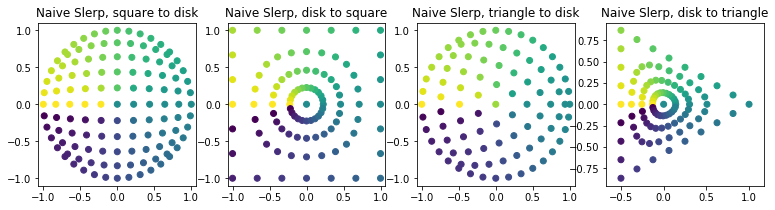

In [24]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Naive Slerp, square to disk')
plt.axis('equal')
plt.scatter(ns_sqdisk.real, ns_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Naive Slerp, disk to square')
plt.axis('equal')
plt.scatter(ns_square.real, ns_square.imag, c=np.angle(std_disk))
plt.subplot(1, 4, 3)
plt.title('Naive Slerp, triangle to disk')
plt.axis('equal')
plt.scatter(ns_tridisk.real, ns_tridisk.imag, c=np.angle(std_tri))
plt.subplot(1, 4, 4)
plt.title('Naive Slerp, disk to triangle')
plt.axis('equal')
plt.scatter(ns_tri.real, ns_tri.imag, c=np.angle(std_disk))

plt.show()

This is a second form of square Naive Slerp. It is more complicated and lacks a closed-form inverse, but is also a diffeomorphism that preserves distances along edges. The difference with the first form of square Naive Slerp is small, less than 0.023 difference in the u or v coordinates at its worst point.

**Square to disk:**

$$
u = \sqrt 2 \left(\sqrt{2+\sqrt 2} \sin \left( \frac{\pi}{8} x \right)
\cos \left( \frac{\pi}{8} y \right) \cos \left( \frac{\pi}{8} xy \right)
- \sqrt{2-\sqrt 2} \cos \left( \frac{\pi}{8} x \right) \sin
\left( \frac{\pi}{8} y \right) \sin \left( \frac{\pi}{8} xy \right)\right),
$$
$$
v = \sqrt 2 \left(\sqrt{2+\sqrt 2} \cos \left( \frac{\pi}{8} x \right)
\sin \left( \frac{\pi}{8} y \right) \cos \left( \frac{\pi}{8} xy \right)
- \sqrt{2-\sqrt 2} \sin \left( \frac{\pi}{8} x \right)
\cos \left( \frac{\pi}{8} y \right) \sin \left( \frac{\pi}{8} xy \right)\right).
$$

In [25]:
def s2d_ns2(z):
    """Naive slerp 2, square to disk"""
    x = z.real
    y = z.imag        
    return np.sqrt(2)*(
        +np.sqrt(2+np.sqrt(2))*np.sin(np.pi/8*x)*np.cos(np.pi/8*y)*np.cos(np.pi/8*x*y)
        -np.sqrt(2-np.sqrt(2))*np.cos(np.pi/8*x)*np.sin(np.pi/8*y)*np.sin(np.pi/8*x*y)
        +1j*np.sqrt(2+np.sqrt(2))*np.cos(np.pi/8*x)*np.sin(np.pi/8*y)*np.cos(np.pi/8*x*y)
        -1j*np.sqrt(2-np.sqrt(2))*np.sin(np.pi/8*x)*np.cos(np.pi/8*y)*np.sin(np.pi/8*x*y))
ns2_sqdisk = s2d_ns2(std_square)

In [26]:
#numerically invert
ns2_square = std_disk.copy()
#ns_tri_b = np.zeros([3,len(std_disk)])
for i in range(len(std_disk)):
    z = std_disk[i]
    xy = np.array([z.real, z.imag])
    def objective(t):
        return abs(s2d_ns2(t.view(dtype=np.complex128)) - z)*1000 
    res = minimize(objective, x0=xy, method='Nelder-Mead')
    ns2_square[i] = res.x.view(dtype=np.complex128)

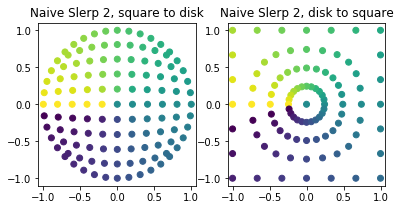

In [27]:
plt.figure(figsize=(13,3))
plt.subplot(1, 4, 1)
plt.title('Naive Slerp 2, square to disk')
plt.axis('equal')
plt.scatter(ns2_sqdisk.real, ns2_sqdisk.imag, c=np.angle(std_square))
plt.subplot(1, 4, 2)
plt.title('Naive Slerp 2, disk to square')
plt.axis('equal')
plt.scatter(ns2_square.real, ns2_square.imag, c=np.angle(std_disk))

plt.show()